In [1]:
using ParallelTemperingMonteCarlo
using BenchmarkTools, Random, StaticArrays


In [2]:
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details

mc_cycles = 1000000 #default 20% equilibration cycles on top

mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=5.32*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

In [3]:
function testdisp!(mc_states,mc_params)
    indices = []
    trial_positions = []
    for state in mc_states
        index=rand(1:mc_params.n_atoms)
        push!(indices,index)
        trial_position = atom_displacement(state,index)
        push!(trial_positions,trial_position)
    end


    return indices,trial_positions
end

function oneatomdisp(state,mc_params)
    index=rand(1:mc_params.n_atoms)
        
        trial_position = atom_displacement(state,index)

    return index,trial_position
end
function atom_disp(mc_states,mc_params)
    indices = Vector{Int}(undef,mc_params.n_traj)
    trial_positions = Vector{Any}(undef,mc_params.n_traj)
    for idx in eachindex(mc_states)
        indices[idx],trial_positions[idx] = oneatomdisp(mc_states[idx],mc_params)
    end
    return indices,trial_positions
end
function justloop(mc_states,mc_params)
    for state in mc_states
        oneatomdisp(state,mc_params)
    end
end
@benchmark testdisp!($mc_states,mc_params)

BenchmarkTools.Trial: 10000 samples with 190 evaluations.
 Range (min … max):  527.358 ns … 19.785 μs  ┊ GC (min … max):  0.00% … 95.92%
 Time  (median):     569.079 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   697.636 ns ±  1.101 μs  ┊ GC (mean ± σ):  11.40% ±  6.97%

  ▆▆▇█▇▆▆▄▄▃▃▃▃▃▂▂▁▂▂▂▁                 ▁▂▂▂▂▂▂▁▁              ▂
  ███████████████████████▇▇▆▅▅▄▅▄▃▂▅▅▆▆████████████▇██▆▆▆▆▆▇▅▆ █
  527 ns        Histogram: log(frequency) by time      1.08 μs <

 Memory estimate: 1.94 KiB, allocs estimate: 39.

In [4]:
@benchmark atom_disp(mc_states,mc_params)

BenchmarkTools.Trial: 10000 samples with 216 evaluations.
 Range (min … max):  336.231 ns … 18.205 μs  ┊ GC (min … max):  0.00% … 96.10%
 Time  (median):     366.824 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   507.417 ns ±  1.011 μs  ┊ GC (mean ± σ):  14.10% ±  6.91%

  ▂▆█▇▆▅▃▃▃▃▃▂▂▁ ▁ ▁                     ▁▂▃▃▃▃▂▂▂▁▁           ▂
  ███████████████████▇▇▇▅▆▆▅▅▅▅▄▄▄▂▃▄▄▅▇██████████████▇▇█▇█▆▆▆ █
  336 ns        Histogram: log(frequency) by time       838 ns <

 Memory estimate: 1.66 KiB, allocs estimate: 35.

In [5]:
@benchmark generate_displacements($mc_states,mc_params)

BenchmarkTools.Trial: 10000 samples with 349 evaluations.
 Range (min … max):  254.427 ns …   7.517 μs  ┊ GC (min … max): 0.00% … 93.83%
 Time  (median):     283.361 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   402.521 ns ± 522.877 ns  ┊ GC (mean ± σ):  9.90% ±  7.38%

   ▆█▂                                                           
  ▅███▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▅▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  254 ns           Histogram: frequency by time          680 ns <

 Memory estimate: 1.23 KiB, allocs estimate: 3.

In [6]:
@benchmark justloop($mc_states,mc_params)

BenchmarkTools.Trial: 10000 samples with 555 evaluations.
 Range (min … max):  207.252 ns … 270.577 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     220.034 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   221.305 ns ±   6.609 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▄█▇▅▄▁                                         
  ▁▁▂▃▃▂▃▂▂▄▅▄▄▅▅▅███████▆▆▅▆▅▅▄▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  207 ns           Histogram: frequency by time          247 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

# Benchmarking

The goal of this notebook is determining the fastest method for mc_cycle. Above is an example of where a vectorised operation is superior, but this is not _always_ true. The main issue is allocations, where generate_displacements is able to predetermine and allocate the required arrays. This can, however, increase overheads in some situations. 

I discovered this while writing the update histogram functions, where using a for-loop is better when _modifying an existing dataset_.

# Outline
To that end, the existing mc_step! generates a vector of displacements, a vector of energies and then tests acceptance in a vectorised fashion. I aim to test several cases:
- benchmark existing step
- ~~all internal operations are wrapped in one function over which we vectorise~~
NB this won't work as different energy methods require different functionality.

- all internal operations are wrapped up in one function over which we loop
- vector operations are separate from the acceptance/exchange, over which we loop

In [7]:
import ParallelTemperingMonteCarlo.MCRun.mc_step!,ParallelTemperingMonteCarlo.MCRun.acc_test!

In [8]:
function test_step!(mc_states,mc_params,pot,ensemble)
    index,trial_position = generate_displacements(mc_states,mc_params)
    energy_vector,dist2_new = get_energy(trial_position,index,mc_states,pot)
    for idx in eachindex(mc_states)
        acc_test!(ensemble,mc_states[idx],energy_vector[idx],index[idx],trial_position[idx],dist2_new[idx])
    end
    return mc_states
end
function test_step_inbounds!(mc_states,mc_params,pot,ensemble)
    index,trial_position = generate_displacements(mc_states,mc_params)
    energy_vector,dist2_new = get_energy(trial_position,index,mc_states,pot)
    for idx in eachindex(mc_states)
        @inbounds acc_test!(ensemble,mc_states[idx],energy_vector[idx],index[idx],trial_position[idx],dist2_new[idx])
    end
    return mc_states
end
@benchmark mc_step!($mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.877 μs … 393.284 μs  ┊ GC (min … max): 0.00% … 96.81%
 Time  (median):     6.257 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.600 μs ±  12.019 μs  ┊ GC (mean ± σ):  4.93% ±  3.08%

  ▂▅▇█▁                                                        
  █████▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▅▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.88 μs         Histogram: frequency by time        11.2 μs <

 Memory estimate: 12.39 KiB, allocs estimate: 69.

In [9]:
@benchmark test_step!($mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.869 μs … 421.836 μs  ┊ GC (min … max): 0.00% … 97.57%
 Time  (median):     6.232 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.589 μs ±  12.617 μs  ┊ GC (mean ± σ):  5.18% ±  3.08%

  ▁▅█▂                                                         
  ████▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.87 μs         Histogram: frequency by time        11.4 μs <

 Memory estimate: 12.39 KiB, allocs estimate: 69.

In [10]:
@benchmark test_step_inbounds!($mc_states,mc_params,pot,ensemble)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  6.010 μs … 403.456 μs  ┊ GC (min … max): 0.00% … 96.47%
 Time  (median):     6.270 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.639 μs ±  11.905 μs  ┊ GC (mean ± σ):  4.85% ±  3.07%

  ▄▆█                                                          
  ███▅▃▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▃▃▄▅▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  6.01 μs         Histogram: frequency by time        11.6 μs <

 Memory estimate: 12.39 KiB, allocs estimate: 69.

In [11]:
function old_atom_move!(mc_state::MCState, i_atom, pot, ensemble)
    #move randomly selected atom (obeying the boundary conditions)
    trial_pos = atom_displacement(mc_state,i_atom)
    
    delta_en_move, dist2_new = energy_update(trial_pos, i_atom, mc_state.config, mc_state.dist2_mat, pot)
    #decide acceptance
    if metropolis_condition(ensemble, delta_en_move, mc_state.beta) >= rand()
        #new config accepted
        mc_state.config.pos[i_atom] = trial_pos #copy(trial_pos)
        mc_state.dist2_mat[i_atom,:] = dist2_new #copy(dist2_new)
        mc_state.dist2_mat[:,i_atom] = dist2_new
        mc_state.en_tot += delta_en_move
        mc_state.count_atom[1] += 1
        mc_state.count_atom[2] += 1
    end
    return mc_state #config, entot, dist2mat, count_acc, count_acc_adjust
end

function old_mc_step!(mc_state::MCState, pot, ensemble, a, v, r)
    ran_atom = rand(1:(a+v+r)) #choose move randomly
    if ran_atom <= a
        mc_state = old_atom_move!(mc_state, ran_atom, pot, ensemble)
    #else if ran <= v
    #    vol_move!(mc_state, pot, ensemble)
    #else if ran <= r
    #    rot_move!(mc_state, pot, ensemble)
    end
    return mc_state
end 
function old_step_test!(mc_states,pot,ensemble,a,v,r)
    for state in mc_states
        state = old_mc_step!(state,pot,ensemble,a,v,r)
    end
    return mc_states
end

old_step_test! (generic function with 1 method)

In [12]:
@benchmark old_step_test!($mc_states,pot,ensemble,13,0,0)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.953 μs … 411.033 μs  ┊ GC (min … max): 0.00% … 97.73%
 Time  (median):     6.188 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.345 μs ±  10.875 μs  ┊ GC (mean ± σ):  4.14% ±  2.76%

  █ ▅                                                          
  █▆█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.95 μs         Histogram: frequency by time        10.5 μs <

 Memory estimate: 10.00 KiB, allocs estimate: 64.

Benchmarking get_energy

In [13]:
indices,trial_positions = generate_displacements(mc_states,mc_params)
 @benchmark get_energy($trial_positions,$indices,$mc_states,pot)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.816 μs … 360.402 μs  ┊ GC (min … max): 0.00% … 97.75%
 Time  (median):     5.033 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.195 μs ±  11.019 μs  ┊ GC (mean ± σ):  5.82% ±  3.23%

  ▃▇█▆▃▂▂▁ ▁                ▂▃▄▅▅▄▄▃▂▂▂▂▃▂▂▁                  ▂
  ███████████▇▄▄▅▅▆▄▅▄▁▃▁▄▄███████████████████▆▇▆▅▆▅▅▆▅▅▅▅▆▆▆ █
  4.82 μs      Histogram: log(frequency) by time      9.25 μs <

 Memory estimate: 11.22 KiB, allocs estimate: 68.

In [14]:
function testenupdate(trial_positions,indices,mc_states,pot)
    energyvector = []
    dist2new = []
    for idx in eachindex(mc_states)
        en,dis2new = get_energy_dimer(trial_positions[idx],indices[idx],mc_states[idx],pot)
        push!(energyvector,en)
        push!(dist2new,dis2new)
    end
    return energyvector,dist2new
end

@benchmark testenupdate($trial_positions,$indices,$mc_states,pot)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.113 μs … 447.565 μs  ┊ GC (min … max): 0.00% … 97.60%
 Time  (median):     5.324 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.553 μs ±  13.158 μs  ┊ GC (mean ± σ):  6.27% ±  3.09%

  ▇██▅▃▂▁  ▁             ▂▃▅▅▅▅▄▃▂▁▂▂▃▃▂▂▁▁                   ▂
  ████████████▇▇▆▆▃▅▂▄▂▄▇██████████████████▇▇▇▆▆▅▃▄▆▇▆▇▆▆▆▅▄▆ █
  5.11 μs      Histogram: log(frequency) by time      9.95 μs <

 Memory estimate: 11.44 KiB, allocs estimate: 103.

# Results and Sampling

Having benchmarked mc_step and mc_cycle, we are at the point where we will need to sample data. The main takeaway here will be whether or not the new sampling step is faster than the old.

The key here is basically to benchmark MCRun.sampling_step+update_rdf+update_histogram and compare this with the new sampling.sampling_step

In [15]:
ptmc_run!(mc_states, move_strat, mc_params, pot, ensemble, results; save_ham = false)

Total number of moves per MC cycle: 13



equilibration done


MC loop done.


[0.00032207039864127617, 0.0003355819105279192, 0.00035643586669873513, 0.0003761266368763596, 0.00039454218517713985, 0.0004237029910114976, 0.0004421172107412197, 0.0004723909772239245, 0.0004812156304097973, 0.0005243981632577579, 0.0005511625643465418, 0.0005790141561770559, 0.0006078988772944163, 0.0006725497172660517, 0.0006981916339397042, 0.0007748543576863903, 0.0008387741248366618, 0.0009760210773909209, 0.0011519080956073147, 0.0014718777251584115, 0.0017162037093697124, 0.0021613630331045967, 0.0027708703053662635, 0.003126654187788658, 0.003344674139491709, 0.0032963132477790524, 0.003010139884167088, 0.002700119946080442, 0.0024652007245660034, 0.002320666555037463, 0.0019794085575286407, 0.0018922077964178326]
done


In [16]:
import ParallelTemperingMonteCarlo.MCRun.sampling_step!,ParallelTemperingMonteCarlo.MCRun.updatehistogram!,ParallelTemperingMonteCarlo.MCRun.updaterdf!

In [17]:
delta_en_hist = (results.en_max - results.en_min) / (results.n_bin - 1)
delta_r2 = 4*start_config.bc.radius2/results.n_bin/5

0.8085575246693824

In [18]:
function testsample(mc_states,mc_params,results,delta_en_hist,delta_r2)
    MCRun.sampling_step!(mc_params,mc_states,1000,false)
    updatehistogram!(mc_params,mc_states,results,delta_en_hist,fullham=false)
    updaterdf!(mc_states,results,delta_r2)
end

@benchmark testsample($mc_states,mc_params,$results,delta_en_hist,delta_r2)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.355 μs …  13.128 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.656 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.687 μs ± 200.443 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁      █▂     ▂▄  ▇▂  ▂   ▃  ▁▄      ▁                      
  ▃█▃▁▁▂▂▃██▂▃█▅▂██▃▃██▂▅█▆▂▇█▄▂██▄▃▅▄▂▃█▆▂▂▂▃▂▂▄▂▂▂▂▂▁▁▁▂▁▁▁ ▃
  7.35 μs         Histogram: frequency by time        8.19 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [19]:
@benchmark ParallelTemperingMonteCarlo.MCSampling.sampling_step!(mc_params,$mc_states,1000,$results,delta_en_hist,delta_r2)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.393 μs …  13.672 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.840 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.835 μs ± 234.991 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                   ▄  ▁     ▁█     ▃                           
  ▁▃▃▁▁▁▁▄▆▂▃▆▂▃▇▃▄█▅▃█▇▃█▆▃██▄▃▅▄▄█▇▂▄▅▃▄▅▃▂▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁ ▃
  7.39 μs         Histogram: frequency by time        8.38 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [20]:
@benchmark MCSampling.update_rdf!($mc_states,$results,delta_r2)


BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.262 μs …  12.431 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.545 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.573 μs ± 202.288 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁      ▆█  ▁   █  ▅▄  ▂   ▄   ▂                             
  ▂█▅▁▁▂▂▂██▂▃█▅▂▇█▄▂██▃▂█▇▂▅█▅▂▅█▄▂▄▅▂▂▅▆▂▂▂▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁ ▃
  7.26 μs         Histogram: frequency by time        8.09 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
@benchmark MCRun.updaterdf!($mc_states,$results,delta_r2)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.265 μs …  13.483 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.550 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.579 μs ± 212.044 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂      ▅█      ▇  ▂▄  ▁   ▃   ▃                             
  ▃█▅▁▁▂▂▂██▃▃█▅▂▅█▆▂██▃▂█▇▂▃█▆▂▄█▆▂▃▄▃▂▄▇▃▂▂▂▂▂▂▃▂▁▁▂▂▁▁▂▁▁▁ ▃
  7.27 μs         Histogram: frequency by time        8.09 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
@benchmark MCRun.updatehistogram!(mc_params,$mc_states,$results,delta_en_hist,fullham=false)

BenchmarkTools.Trial: 10000 samples with 973 evaluations.
 Range (min … max):  72.033 ns … 141.664 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     74.790 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   75.045 ns ±   3.118 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

      █▁     ▂▄  ▃▆      ▂▁  ▁▃       ▁                         
  ▁▂▃███▄▆▄▄▅██▇███▇▅▆▅▅▇██▇▆██▇▅▆▅▄▆██▆▅▃▃▃▂▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁ ▄
  72 ns           Histogram: frequency by time         79.9 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [24]:
@benchmark MCSampling.update_histograms!($mc_states,$results,delta_en_hist)

BenchmarkTools.Trial: 10000 samples with 983 evaluations.
 Range (min … max):  63.498 ns … 99.038 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     67.409 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   67.427 ns ±  1.515 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                   ▂        ▄█▇▅▂                              
  ▂▂▁▂▂▂▂▃▃▃▃▂▂▃▄▄▆███▇▄▃▄▅██████▆▄▄▄▄▅▅▅▅▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂ ▃
  63.5 ns         Histogram: frequency by time        71.9 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

The main bottleneck seems to be the speed of a loop over states or looping over states (confusingly worded, but makes sense)

The megacell below was used to maximise the efficiency of the update_energy_tot function, a bottleneck that went from 60 to 30 ns

In [25]:
# @benchmark MCRun.sampling_step!(mc_params,$mc_states,1000,false)
# function wrapper_sampling(mc_params,mc_states,save_index,delta_en_hist)
#     if rem(save_index, mc_params.mc_sample) == 0
#         for state in mc_states
#             state = MCSampling.update_energy_tot(state)
#         end
#     end
#     return mc_states,results
# end

# function test_update(mc_states,save_index,mc_params)
#     if rem(save_index, mc_params.mc_sample) == 0
#         for indx_traj=1:mc_params.n_traj            
#             mc_states[indx_traj].ham[1] += mc_states[indx_traj].en_tot
#                 #add E,E**2 to the correct positions in the hamiltonian
#             mc_states[indx_traj].ham[2] += (mc_states[indx_traj].en_tot*mc_states[indx_traj].en_tot)            
#         end
#     end 
# end


# @benchmark wrapper_sampling(mc_params,$mc_states,1000,delta_en_hist)
# @benchmark test_update($mc_states,1000,mc_params)
# function upydatey(mc_states)
#     for indx_traj in eachindex(mc_states)      
#         mc_states[indx_traj].ham[1] += mc_states[indx_traj].en_tot
#             #add E,E**2 to the correct positions in the hamiltonian
#         mc_states[indx_traj].ham[2] += (mc_states[indx_traj].en_tot*mc_states[indx_traj].en_tot)            
#     end
# end

# function test_update2(mc_states,save_index,mc_params)
#     if rem(save_index, mc_params.mc_sample) == 0
#         upydatey(mc_states)
#     end 
# end
# @benchmark test_update2($mc_states,1000,mc_params)

BenchmarkTools.Trial: 10000 samples with 994 evaluations.
 Range (min … max):  31.228 ns … 52.018 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     32.086 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.732 ns ±  3.045 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▂█▄█▅▄▄▂▁                                          ▁  ▂    ▂
  ███████████▆▅▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁█▁▁█▅▅█ █
  31.2 ns      Histogram: log(frequency) by time      49.7 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

# Testing Sampling

In [3]:
ptmc_run!(mc_states, move_strat, mc_params, pot, ensemble, results; save_ham = false)

Total number of moves per MC cycle: 13



equilibration done


MC loop done.


[0.0003234110423948385, 0.00034130435146749016, 0.0003571979730485569, 0.0003751826872688714, 0.00038929116332445156, 0.00041586364789964576, 0.00043669694264594094, 0.0004595895593319723, 0.0004890435704389878, 0.0005157634753972615, 0.0005536751008066922, 0.0005723147050125483, 0.0006169481887285358, 0.000683777774995162, 0.0007252243017238607, 0.000822837124956102, 0.0008936290651810269, 0.0009485259670130599, 0.0011550216114052253, 0.001486674414643203, 0.0017357931127196526, 0.0022538799773156406, 0.002685202167626738, 0.0030124683418126814, 0.003227185612361041, 0.0031974041582545276, 0.003076489630752461, 0.002817309162204895, 0.0025391775980580186, 0.0022260287657100224, 0.002074304958103143, 0.0020101649064780125]
done


In [4]:
data = [results.en_histogram[i] for i in 1:n_traj]

32-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 1208.0, 13026.0, 56780.0, 129808.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 847.0, 9440.0, 43269.0, 106423.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 482.0, 6414.0, 31944.0, 85883.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 346.0, 4459.0, 23659.0, 67888.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 207.0, 2928.0, 16937.0, 52532.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 121.0, 1868.0, 11622.0, 39475.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 80.0, 1247.0, 8286.0, 29349.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 845.0, 5828.0, 22120.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.

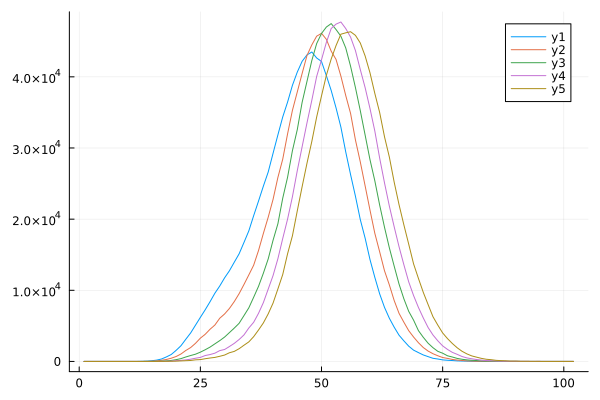

In [16]:
plot(data[28:32])

In [9]:
multihistogram(results,temp)

B Vector Calculated
A Matrix Calculated


LinearAlgebra.SingularException: LinearAlgebra.SingularException(32)